In [1]:
import numpy as np
import roboticstoolbox as rtb
from spatialmath import *
from math import pi
import matplotlib.pyplot as plt
from matplotlib import cm
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

%matplotlib notebook

We will instantiate a model of the Puma 560 robot which has well known inertial parameters

In [2]:
p560 = rtb.models.DH.Puma560()

and show its configuration in a typical desktop working pose

<IPython.core.display.Javascript object>


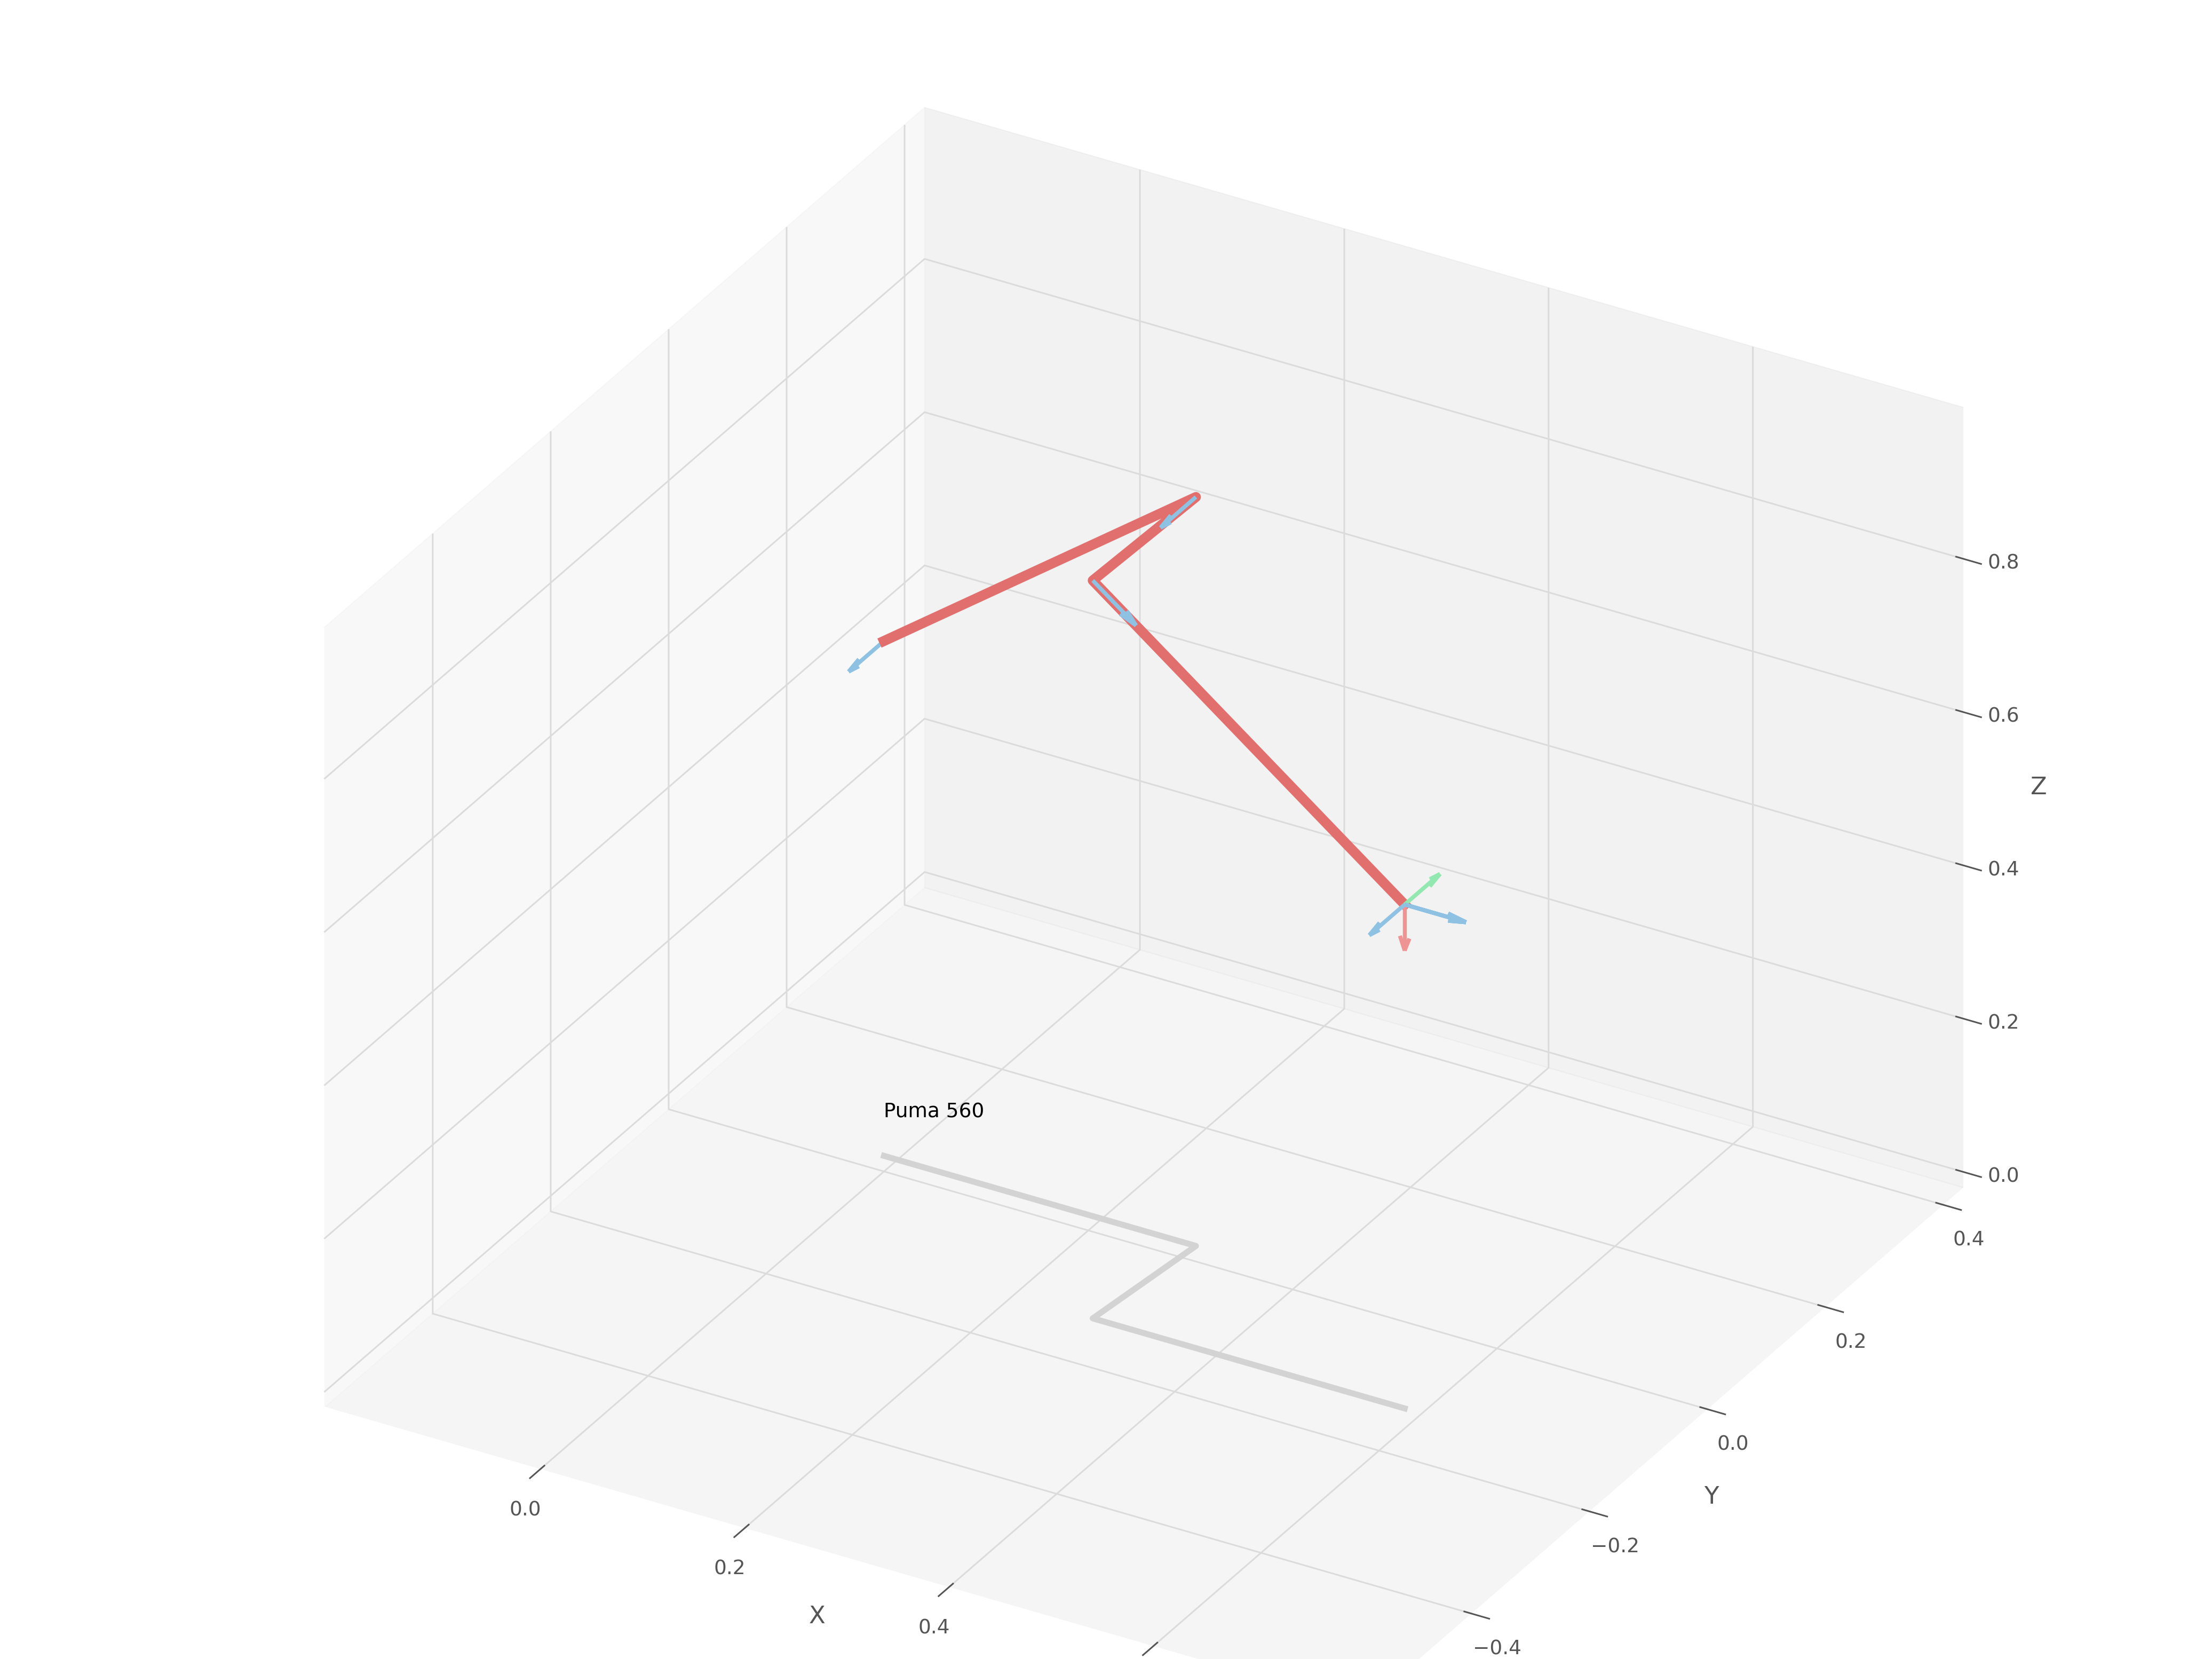

In [16]:
p560.plot(p560.qn);

The rigid-body equations of motion for a robot are a set of coupled differential equations
$$
\mathbf{M}(\mathit{\ddot{q}}) \mathit{\ddot{q}} + \mathbf{C}(\mathit{q}, \mathit{\dot{q}}) \mathit{\dot{q}} + \mathbf{g}(\mathit{q}) = \mathit{\tau}
$$
which relate the motion of the robot $(\mathit{q}, \mathit{\dot{q}}, \mathit{\ddot{q}})$ and the applied torque $\mathit{\tau}$.  The coefficients in this equation are:
- the inertia or mass matrix $\mathbf{M}(\mathit{\ddot{q}})$ which is a function of joint configuration
- the centripetal and Coriolis or velocity term which is a function of joint configuration and rate
- the gravity load which is a function of joint configuration

If the robot is not moving, that is $\mathit{q} = \mathit{\dot{q}} = 0$ then the equation becomes
$$
\mathbf{g}(\mathit{q}) = \mathit{\tau}
$$
where $\mathit{\tau}$ is the torque required for this condition $\mathit{q} = \mathit{\dot{q}} = 0$ to be true, that is, the torque required to stop the robot falling under its own weight.  The toolbox can compute this

In [4]:
p560.gravload(p560.qn)

array([       0,    31.64,    6.035,        0,  0.02825,        0])

and it shows, as expected, that the shoulder is exerting significant torque to hold the arm up and stationary.

The inertia matrix relates torque to joint acceleration and is the mass in a multi-dimensional version of Newton's second law $F = m a$.  In this configuration the inertia matrix is

In [5]:
p560.inertia(p560.qn)

array([[   3.659,  -0.4044,   0.1006, -0.002517,        0,        0],
       [ -0.4044,    4.414,   0.3509,        0,  0.00236,        0],
       [  0.1006,   0.3509,   0.9378,        0,  0.00148,        0],
       [-0.002517,        0,        0,   0.1925,        0, 2.828e-05],
       [       0,  0.00236,  0.00148,        0,   0.1713,        0],
       [       0,        0,        0, 2.828e-05,        0,   0.1941]])

The diagonal elements $M_{jj}$ indicate the inertia experienced by the joint $j$, ie. Newton's second law for this joint is $\tau_j  = M_{jj} \ddot{q}_j$.

The matrix is symmetric and the off-diagonal terms $M_{ij} = M_{ji}$ couple acceleration of one joint into a disturbance torque on another joint, ie.  $\tau_j = M_{ij} \ddot{q}_i$.

The inertia matrix is a function of joint configuration, that is, the elements of the inertia matrix change as we vary the angles of joints 1 and 2, ie. $q_2$ and $q_3$.  It is this configuration varying inertia and coupling between joints that is a fundamental challenge for high-quality joint control.

In [6]:
N = 100
(Q2, Q3) = np.meshgrid(np.linspace(-pi, pi, N), np.linspace(-pi, pi, N))
M11 = np.zeros((N,N))
M12 = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        M = p560.inertia(np.r_[0, Q2[i,j], Q3[i,j], 0, 0, 0])
        M11[i,j] = M[0,0]
        M12[i,j] = M[0,1]

The inertia "seen" by joint 1 varies as a function of $q_2$ and $q_3$ as shown below

<IPython.core.display.Javascript object>


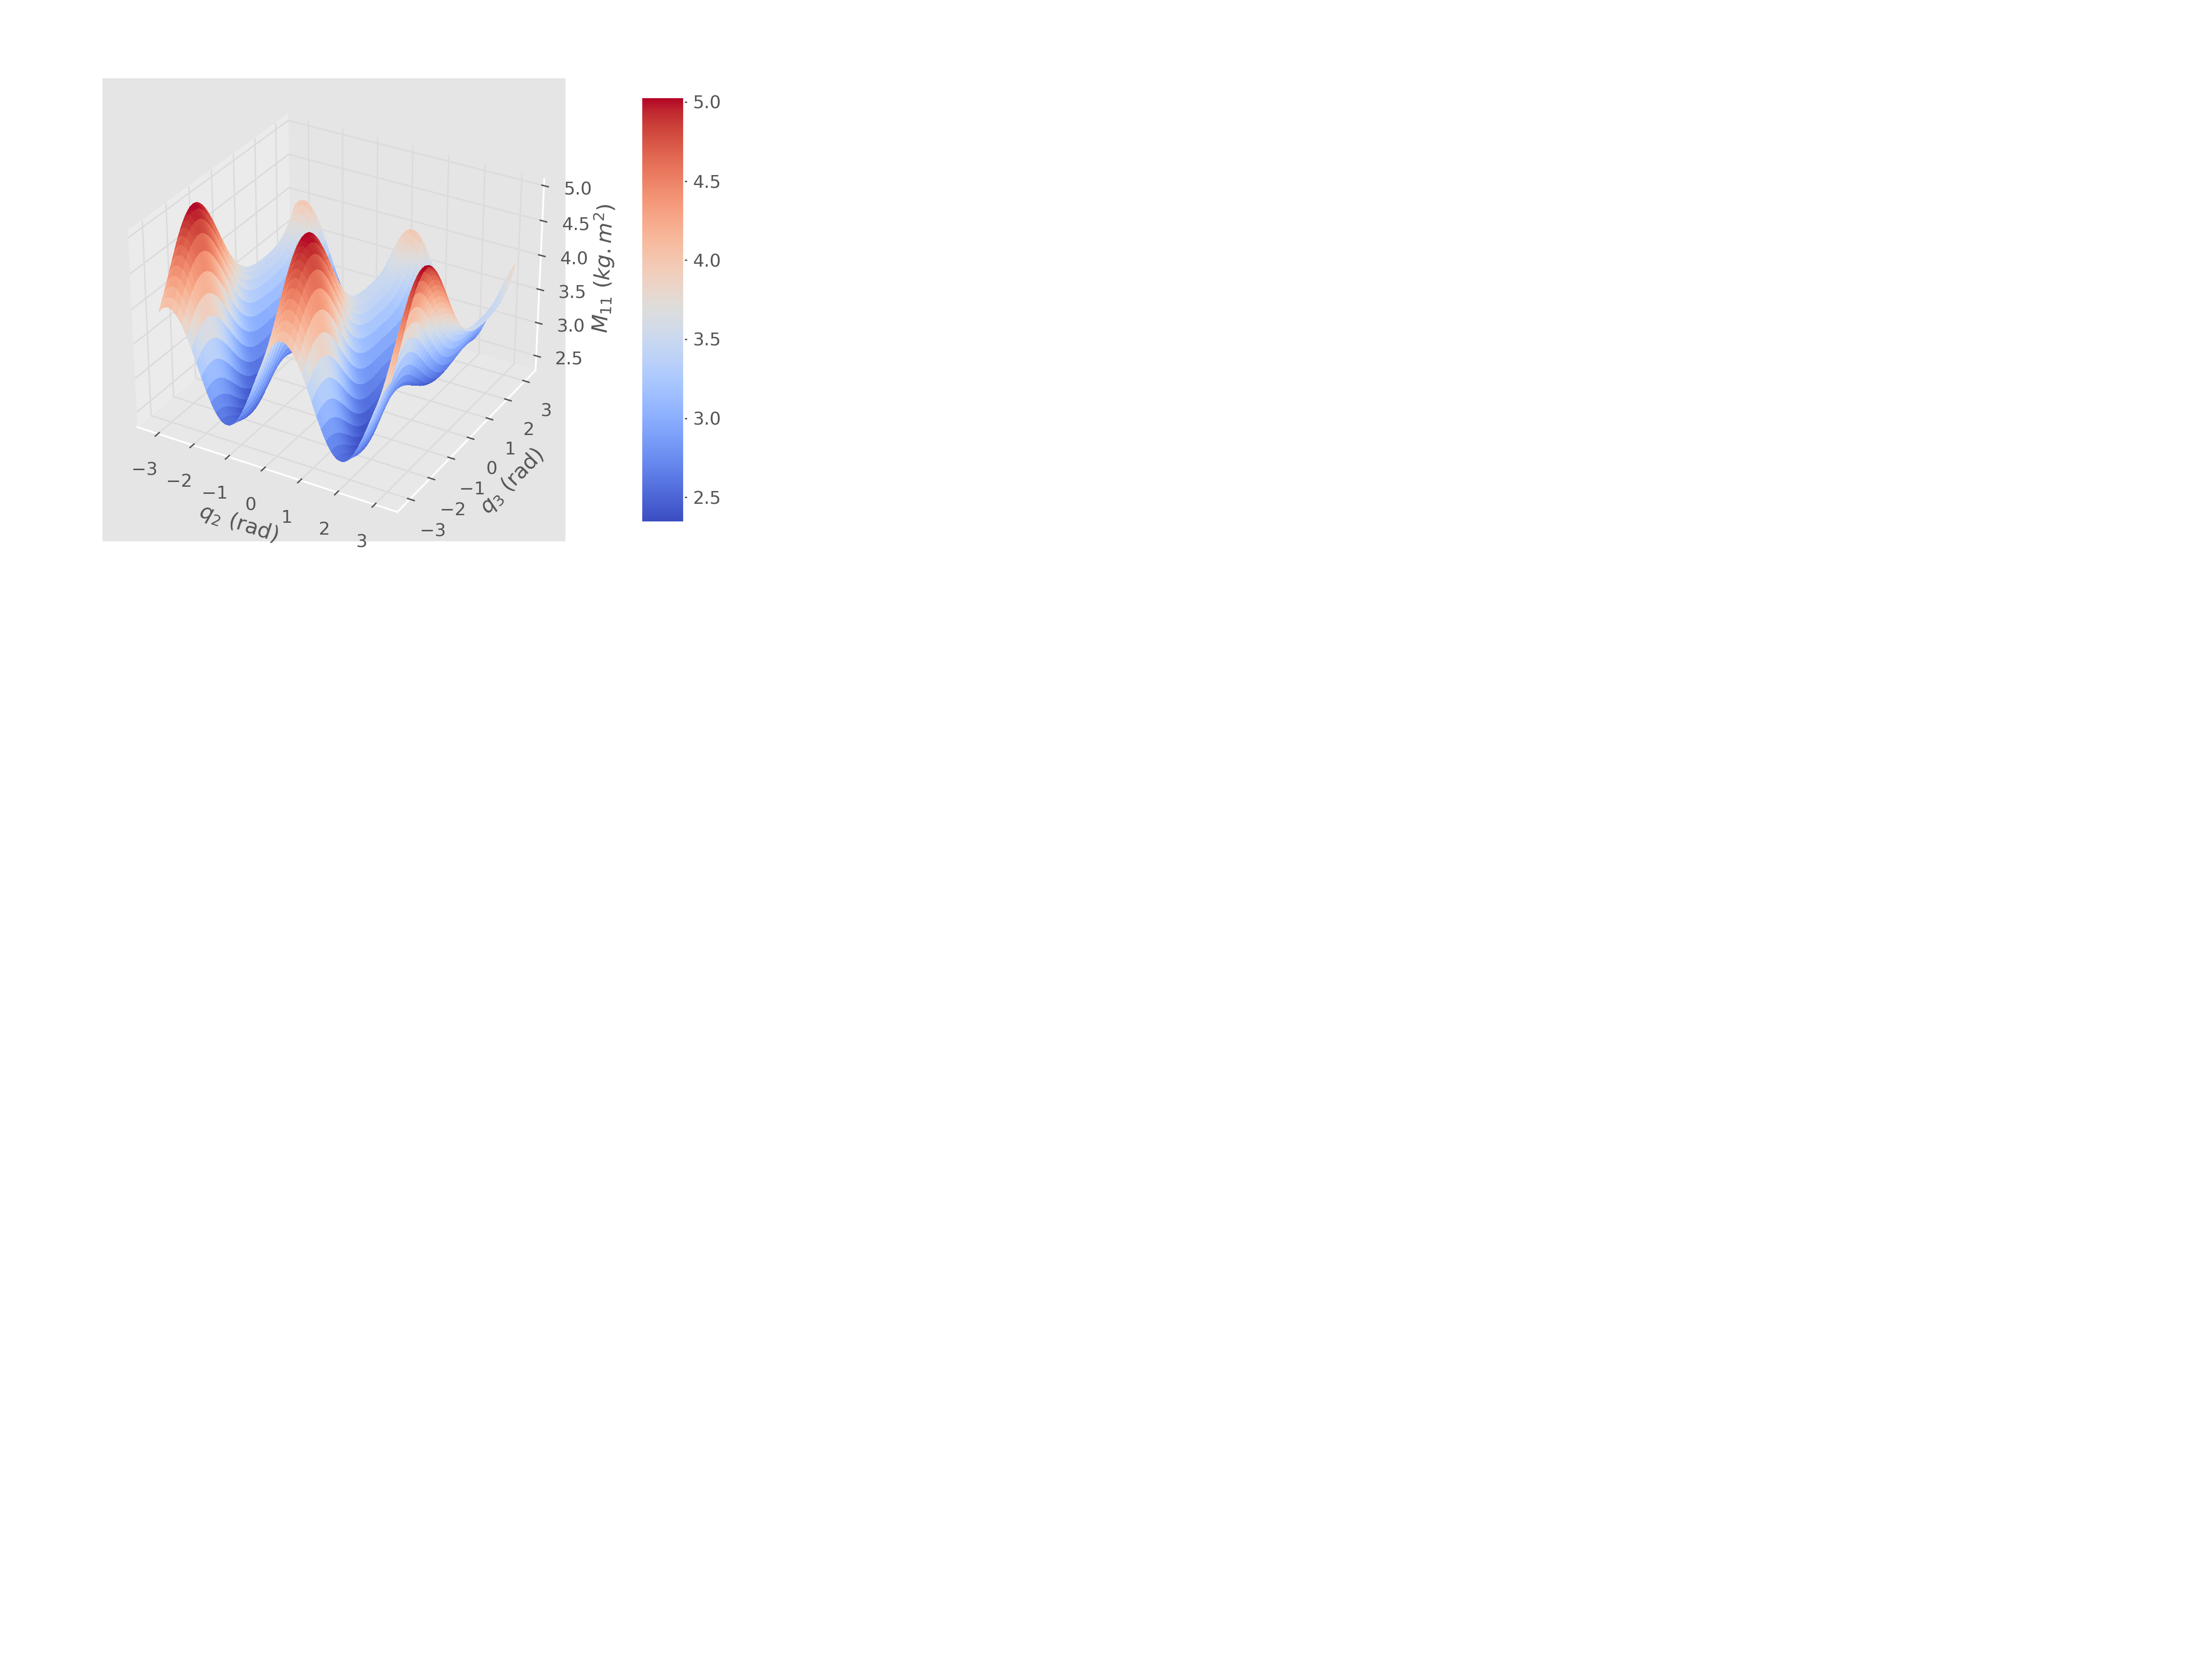

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Q2, Q3, M11, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.9, aspect=10, pad=0.12)
ax.set_xlabel('$q_2$ (rad)')
ax.set_ylabel('$q_3$ (rad)')
ax.set_zlabel('$M_{11}$ ($kg.m^2$)')
plt.show()

The ratio of maximum to minimum values is

In [8]:
M11.max() / M11.min()

2.155984921575918

The coupling inertia between joints 1 and 2 also varies with configuration and we can plot that as well

<IPython.core.display.Javascript object>


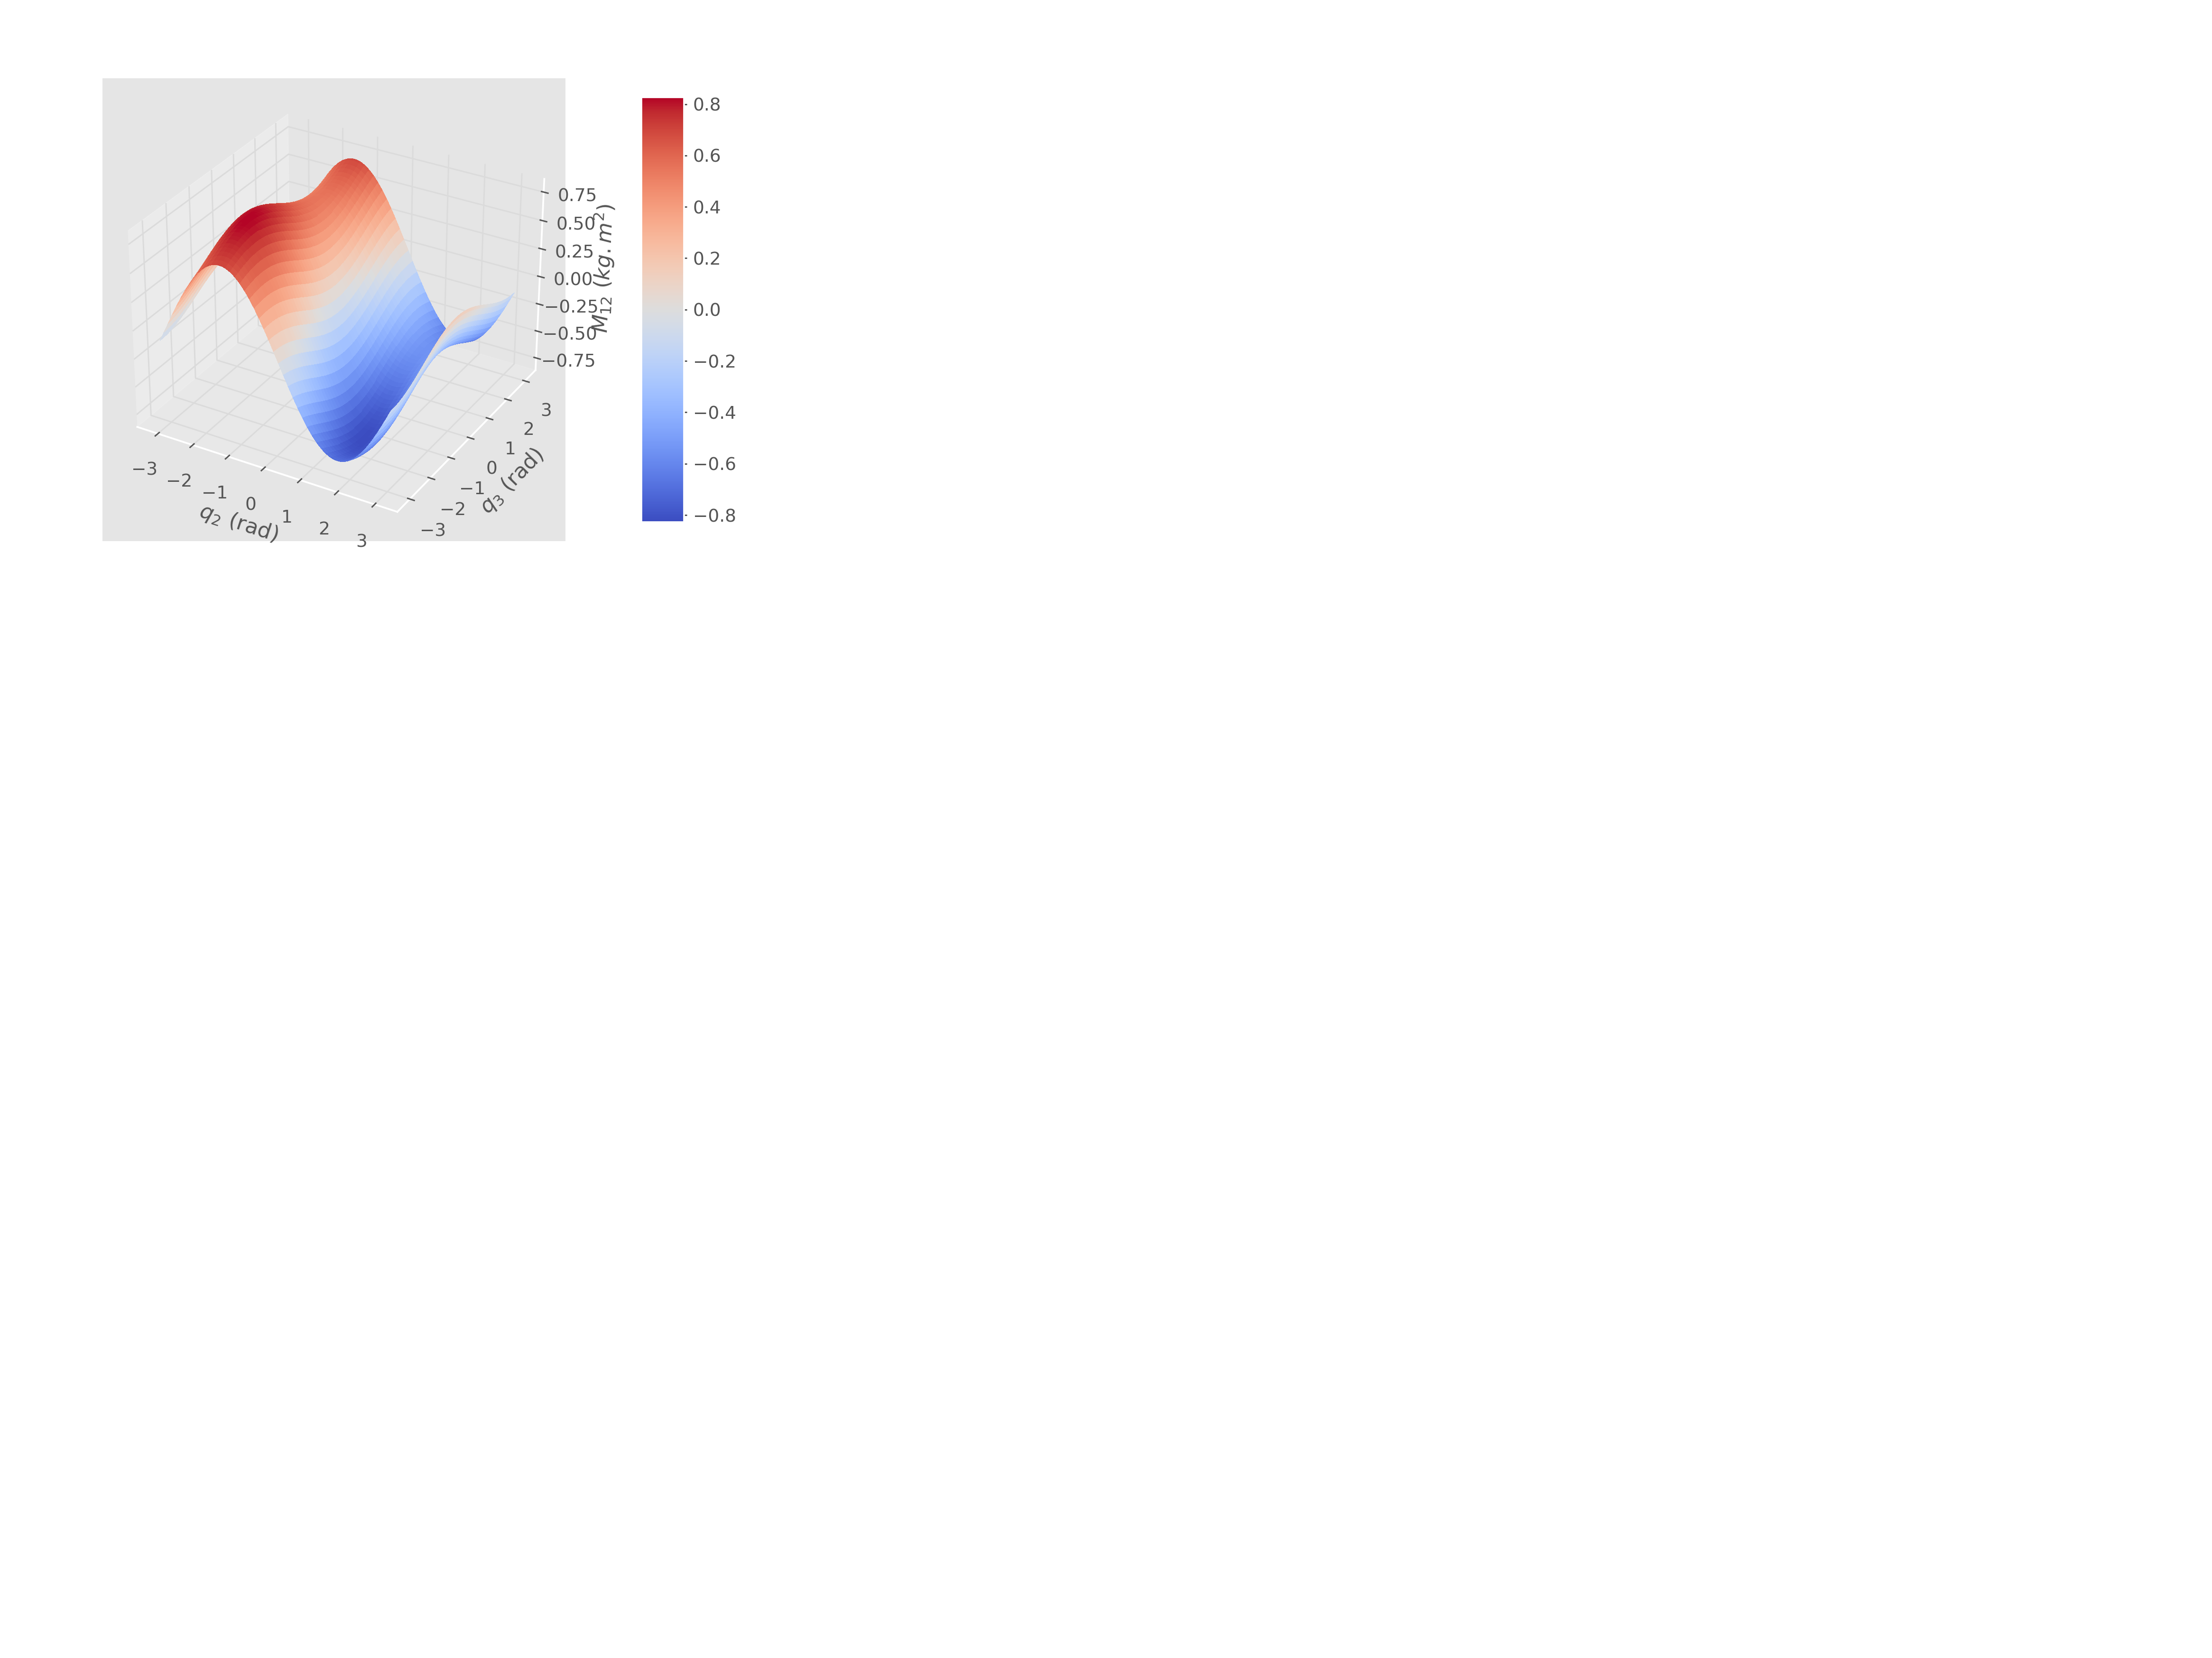

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Q2, Q3, M12, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.9, aspect=10, pad=0.12)
ax.set_xlabel('$q_2$ (rad)')
ax.set_ylabel('$q_3$ (rad)')
ax.set_zlabel('$M_{12}$ ($kg.m^2$)')
plt.show()

The velocity terms are a bit harder to comprehend but they mean that rotation of one joint (and its link) can exert a torque on other joints.  Consider that the should joint is rotating at 1 rad/sec, then the torque will be 

In [10]:
qd = np.r_[0, 1, 0, 0, 0, 0]
p560.coriolis(p560.qn, qd) @ qd

array([  -0.567,        0,  -0.3858,        0, 4.134e-05,        0])

and we see that it exerts a torque on the waist and elbow joints.

The algorithms to compute the various terms in the rigid-body equations of motion are based on the recursive Newton-Euler algorithm

In [11]:
p560.rne(p560.qn, np.zeros((6,)), np.zeros((6,)))

array([       0,    31.64,    6.035,        0,  0.02825,        0])

which computes $\tau = \mbox{rne}(\mathit{q}, \mathit{\dot{q}}, \mathit{\dot{q}})$ and can accept additional arguments such as gravity or a wrench applied to the end-effector.  In the Toolbox this algorithm is implemented in C for maximum performance.

The example above computes the gravity load, cross check it with the result computed earlier.


We can rearrange the equations of motion as
$$
\mathit{\ddot{q}} = \mathbf{M}(\mathit{\ddot{q}})^{-1} \left\{ \mathit{\tau} - \mathbf{C}(\mathit{q}, \mathit{\dot{q}}) \mathit{\dot{q}} - \mathbf{g}(\mathit{q}) \right\} 
$$
which is the joint acceleration for a robot in the state $(\mathit{q}, \mathit{\dot{q}})$ with an applied torque of $\mathit{\tau}$.

If we integrate this we can compute the trajectory of the joint coordinates (and velocities) as a function of time

In [12]:
p560nf = p560.nofriction()
tg = p560nf.fdyn(5, p560.qn, dt=0.05)

The first line needs some explanation.  The Toolbox can model two types of joint friction:
- viscous friction which is linearly related to joint velocity
- Coulomb friction which is **non-linearly** related to joint velocity

Coulomb friction is a _harsh_ non-linearity and it causes the numerical integrator to take very small times steps, so the result will take many minutes to compute.  To speed things up, at the expense of some modeling fidelity, we set the Coulomb friction to zero, but retain the viscous friction.  The `nofriction()` method returns a clone of the robot with its friction parameters modified.

The computed joint configuration trajectory is

In [13]:
tg.q

array([[       0,   0.7854,    3.142,        0,   0.7854,        0],
       [-0.001454,   0.7675,    3.133, -1.717e-05,   0.7853, -1.512e-08],
       [-0.003912,   0.7365,    3.118, -4.582e-05,    0.785, -4.506e-08],
       [-0.00637,   0.7055,    3.103, -7.446e-05,   0.7848, -7.5e-08],
       [-0.009225,   0.6509,    3.084, -0.0001022,   0.7843, -1.79e-07],
       [-0.01243,    0.575,    3.062, -0.0001291,   0.7835, -3.494e-07],
       [-0.01564,   0.4991,    3.039, -0.000156,   0.7827, -5.198e-07],
       [-0.01885,   0.4232,    3.017, -0.0001829,    0.782, -6.901e-07],
       [-0.01829,   0.3167,     3.01, -0.0001608,   0.7808, -4.723e-07],
       [-0.01623,    0.198,    3.009, -0.0001192,   0.7795, -1.008e-07],
       [-0.01418,  0.07928,    3.009, -7.756e-05,   0.7782, 2.707e-07],
       [-0.01212, -0.03941,    3.008, -3.596e-05,   0.7769, 6.421e-07],
       [-0.006575,  -0.1645,    3.022, 1.513e-05,   0.7755, 1.62e-06],
       [ 0.00807,  -0.3062,     3.07, 9.094e-05,   0.7741, 4

which we can plot using a Toolbox convenience function

<IPython.core.display.Javascript object>


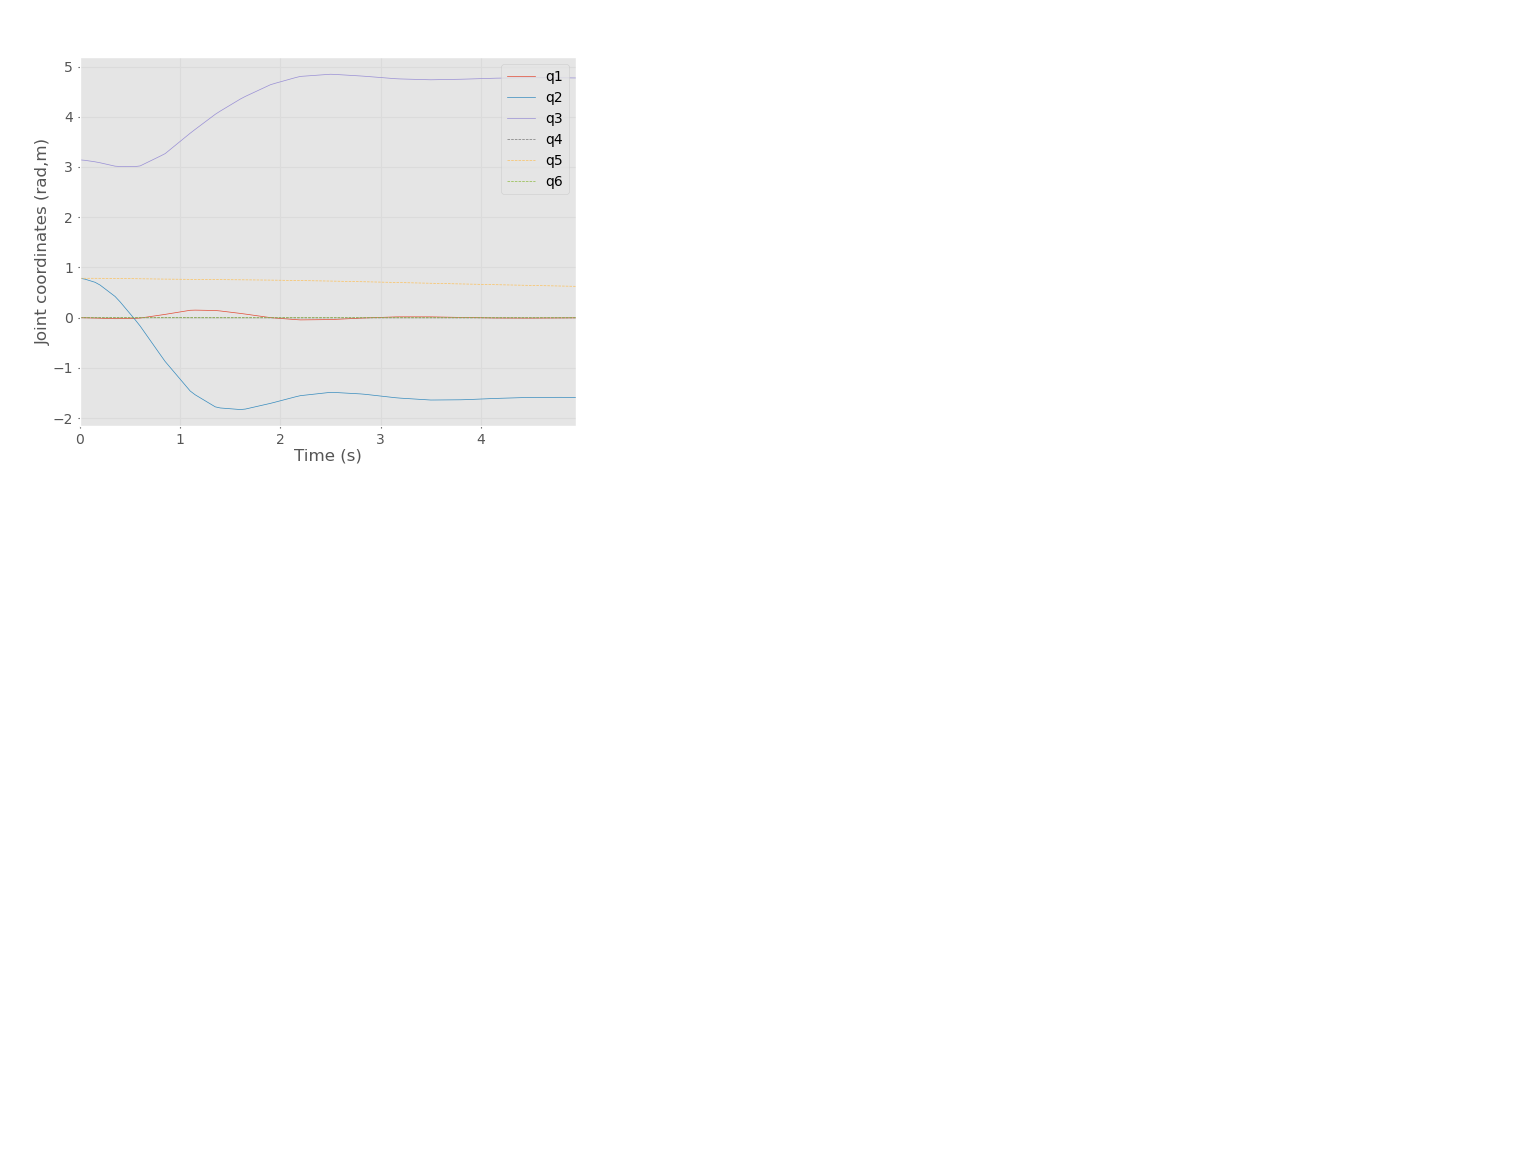

In [14]:
rtb.tools.trajectory.qplot(tg.q, tg.t)

or we can animate it, showing the robot collapsing under gravity

In [15]:
p560.plot(tg.q.T);

ValueError: expecting (None, 6) but got (6, 100)

_Note: this animation is not working in Jupyter notebook..._

The motion of the robot quickly dies out and it hangs downward, this loss of energy is due to the viscous friction in the robot's joints.